In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Работа с данными

Загрузка данных

In [2]:
ds = pd.read_csv('house_pricing/train.csv')
ds.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Проверим на пропущенные значения

In [3]:
ds.isnull().sum().sum()

6965

In [4]:
s = ds.isnull().sum()
s = s[s>0]
s.sort_values(ascending=False)/len(ds)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

У некоторых признаков пропущено 99% значений.

Что это вообще за признаки?

In [5]:
!cat house_pricing/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Кажется все пропуски запланированы и преднамерены

In [6]:
X = ds.drop(['SalePrice','Id'],1)
Y = ds['SalePrice']

Заранее выделим hold out датасет

In [7]:
hold_out_inds = sorted(np.random.choice(range(len(ds)), size=int(len(ds)*0.1), replace=False))
no_hold_inds = [x for x in range(len(ds)) if x not in hold_out_inds]
len(no_hold_inds), len(hold_out_inds)

(1314, 146)

Определим категориальные и вещественные признаки

In [8]:
cat_feats = list(X.dtypes[X.dtypes==np.dtype('O')].index)
cat_feats += ['MSSubClass']

real_feats = X.drop(cat_feats,1).columns

Заполним пропуски

In [9]:
for f in ['LotFrontage','MasVnrArea']:
    X[f] = X[f].fillna(0)
for f in ['GarageYrBlt']:
    m = X.iloc[no_hold_inds][f].mean()
    X[f] = X[f].fillna(m).isna()
for f in cat_feats:
    X[f] = X[f].fillna('NA')

Заранее создадим датасет как для деревянных моделей (просто закодированный), так и для линейных (дополнительно one hot encoding)

In [10]:
X_enc = X.copy()
for f in cat_feats:
    X_enc[f] = LabelEncoder().fit_transform(X[f].astype(str))
X_enc[real_feats] = MinMaxScaler().fit_transform(X_enc[real_feats])

In [11]:
X_ohe = pd.concat([pd.get_dummies(X_enc[cat_feats]),X_enc[real_feats]],1)

# Случайный лес и важность признаков

Точность предсказаний случайным лесом

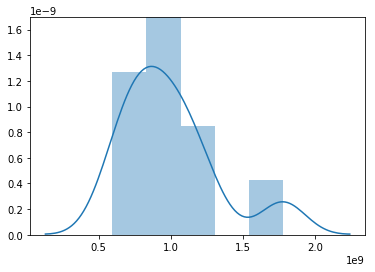

In [12]:
cvs = -cross_val_score(RandomForestRegressor(), X_enc.iloc[no_hold_inds],Y[no_hold_inds],
                      cv=10, scoring='neg_mean_squared_error')
sns.distplot(cvs)

Важность признаков по версии случайного леса

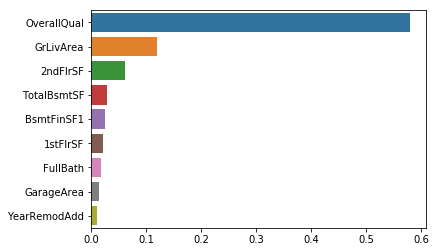

In [13]:
rf = RandomForestRegressor()
rf.fit(X_enc.iloc[no_hold_inds], Y.iloc[no_hold_inds])

feat_imps = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imps = feat_imps[feat_imps>=0.01]
sns.barplot(x=feat_imps.values, y=feat_imps.index)

# Стекинг

In [14]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(X_test.iloc[:,0], dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

Обучаем базовые модели

In [15]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LinReg features...')
meta_tr, meta_te = get_meta_features(Ridge(), X_ohe.iloc[no_hold_inds], Y.iloc[no_hold_inds],
                                     X_ohe.iloc[hold_out_inds], stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(RandomForestRegressor(), X_enc.iloc[no_hold_inds], Y.iloc[no_hold_inds],
                                     X_enc.iloc[hold_out_inds], stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('XGB features...')
meta_tr, meta_te = get_meta_features(XGBRegressor(), X_ohe.iloc[no_hold_inds], Y.iloc[no_hold_inds],
                                     X_ohe.iloc[hold_out_inds], stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('xgb_pred')

LinReg features...
RF features...
XGB features...
[23:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:08] WARNING: /workspace/src/objective/regression_obj.c

Обучаем обобщающую модель

In [16]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [17]:
lr_meta = Ridge()
lr_meta.fit(X_meta_train, Y.iloc[no_hold_inds])
y_pred_meta_test = lr_meta.predict(X_meta_test)

# Сравнение результатов

Простой случайный лес

In [18]:
rf = RandomForestRegressor()
rf.fit(X_enc.iloc[no_hold_inds], Y.iloc[no_hold_inds])
y_pred_rf_test = rf.predict(X_enc.iloc[hold_out_inds])

Простой xgboost

In [19]:
xgb = XGBRegressor()
xgb.fit(X_enc.iloc[no_hold_inds], Y.iloc[no_hold_inds])
y_pred_xgb_test = xgb.predict(X_enc.iloc[hold_out_inds])

[23:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Близость предсказаний к оригиналу

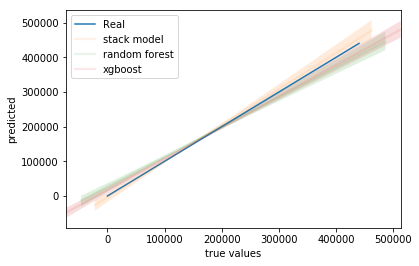

In [20]:
plt.plot([0,Y.iloc[hold_out_inds].max()],[0,Y.iloc[hold_out_inds].max()], label='Real')
sns.regplot(Y.iloc[hold_out_inds].values, y_pred_meta_test, label='stack model',
            scatter=False, scatter_kws={'alpha':0.1}, line_kws={'alpha':0.1})
sns.regplot(Y.iloc[hold_out_inds].values, y_pred_rf_test, label='random forest',
            scatter=False, scatter_kws={'alpha':0.1}, line_kws={'alpha':0.1})
sns.regplot(Y.iloc[hold_out_inds].values, y_pred_xgb_test, label='xgboost',
            scatter=False, scatter_kws={'alpha':0.1}, line_kws={'alpha':0.1})
plt.xlabel('true values')
plt.ylabel('predicted')

plt.legend()
plt.show()

Линия stack model ближе всех к настоящим значениям

Вычисдим различные метрики

In [21]:
res_ds = []
y = Y.iloc[hold_out_inds].values
for f, preds in [('meta', y_pred_meta_test), ('rf', y_pred_rf_test),('xgb', y_pred_xgb_test)]:
    res_ds.append(pd.Series({
        'mae':mean_absolute_error(y, preds),
        'mse':mean_squared_error(y, preds),
        'mspe':(((y-preds)/y)**2).mean(),
                            'r2':r2_score(Y.iloc[hold_out_inds], preds),
                             }, name=f))
res_ds = pd.concat(res_ds,1).T

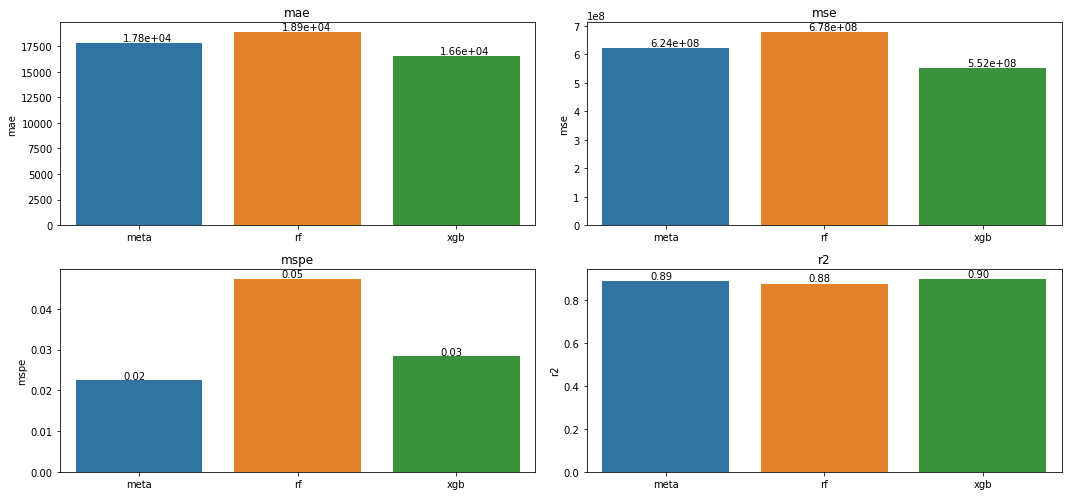

In [22]:
plt.figure(figsize=(15,7))
for idx, c in enumerate(res_ds):
    plt.subplot(2,2,idx+1)
    sns.barplot(res_ds.index, res_ds[c])
    plt.title(c)
    for j, v in enumerate(res_ds[c]):
        plt.text(j-0.1, v*1.01, f'{v:.2f}' if c not in ['mse','mae'] else f'{v:.2e}')
plt.tight_layout()
plt.show()

Stacking модель проигрывает только в улавливании дисперсии искомой величины. Наверное из-за того, что она совсем её не видела, а знает только искажённые результаты базовых моделей.